In [1]:
cd set3

/media/datastorage/Phong/ufc101/set3


In [2]:
ls -l

total 28641688
-rw-rw-r-- 1 bribeiro bribeiro         93 jan 30 13:25 checkpoint
-rw-rw-r-- 1 bribeiro bribeiro  138864586 jan 22 00:43 DenseNet201_CNNRNN2-set3.data-00000-of-00001
-rw-rw-r-- 1 bribeiro bribeiro        836 jan 22 00:43 DenseNet201_CNNRNN2-set3.index
-rw-rw-r-- 1 bribeiro bribeiro 2838897848 jan 19 21:41 DenseNet201_CNNRNN_test_100_set3.pickle
-rw-rw-r-- 1 bribeiro bribeiro      29696 jan 19 21:41 DenseNet201_CNNRNN_test_labels_set3.npy
-rw-rw-r-- 1 bribeiro bribeiro 7392194652 jan 19 21:36 DenseNet201_CNNRNN_train_100_set3.pickle
-rw-rw-r-- 1 bribeiro bribeiro      77120 jan 19 21:41 DenseNet201_CNNRNN_train_labels_set3.npy
-rw-rw-r-- 1 bribeiro bribeiro 1067756051 jan 26 03:25 DenseNet201_Transformer-set3.data-00000-of-00001
-rw-rw-r-- 1 bribeiro bribeiro       4586 jan 26 03:25 DenseNet201_Transformer-set3.index
-rw-rw-r-- 1 bribeiro bribeiro  159836089 jan 30 13:25 EffB7_CNNRNN2-set3.data-00000-of-00001
-rw-rw-r-- 1 bribeiro bribeiro        836 jan 30 13:25 EffB7_CN

In [3]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

MAX_SEQ_LENGTH = 40
NUM_FEATURES = 2560

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 9624
Total videos for testing: 3696


,video_name,tag
1512,v_Bowling_g10_c05.avi,Bowling
5651,v_PlayingCello_g12_c05.avi,PlayingCello
9319,v_WalkingWithDog_g22_c04.avi,WalkingWithDog
3171,v_GolfSwing_g12_c01.avi,GolfSwing
9000,v_Typing_g04_c01.avi,Typing
6174,v_PlayingPiano_g07_c04.avi,PlayingPiano
9074,v_Typing_g23_c02.avi,Typing
1585,v_BoxingPunchingBag_g04_c02.avi,BoxingPunchingBag
3325,v_Hammering_g05_c03.avi,Hammering
5169,v_Mixing_g07_c02.avi,Mixing


In [6]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


In [7]:

def build_feature_extractor():
    feature_extractor = keras.applications.EfficientNetB7(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.efficientnet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

2023-01-29 22:09:33.983730: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 22:09:34.544381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1


In [6]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress', 'Biking', 'Billiards', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats', 'Bowling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'BreastStroke', 'BrushingTeeth', 'CleanAndJerk', 'CliffDiving', 'CricketBowling', 'CricketShot', 'CuttingInKitchen', 'Diving', 'Drumming', 'Fencing', 'FieldHockeyPenalty', 'FloorGymnastics', 'FrisbeeCatch', 'FrontCrawl', 'GolfSwing', 'Haircut', 'HammerThrow', 'Hammering', 'HandstandPushups', 'HandstandWalking', 'HeadMassage', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'IceDancing', 'JavelinThrow', 'JugglingBalls', 'JumpRope', 'JumpingJack', 'Kayaking', 'Knitting', 'LongJump', 'Lunges', 'MilitaryParade', 'Mixing', 'MoppingFloor', 'Nunchucks', 'ParallelBars', 'PizzaTossing', 'PlayingCello', 'PlayingDaf', 'PlayingDhol', 'PlayingFlute', 'PlayingGuitar', 'PlayingPiano', 'PlayingSitar', 'PlayingTabla', 'P

2023-01-30 15:54:38.141263: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 15:54:38.680909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1


In [9]:
from tqdm import tqdm

def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in tqdm(enumerate(video_paths)):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


# train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

# print(f"Frame features in train set: {train_data[0].shape}")
# print(f"Frame masks in train set: {train_data[1].shape}")

0it [00:00, ?it/s]2023-01-29 22:09:48.162407: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-01-29 22:09:48.361284: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-29 22:09:48.361694: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-29 22:09:48.361731: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-29 22:09:48.362134: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-29 22:09:48.362215: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
3696it [3:19:42,  3.24s/it]


In [10]:
train_data, train_labels = prepare_all_videos(train_df, "train")

9624it [8:44:14,  3.27s/it]


In [ ]:
# Utility for our sequence model.
# Bidirectional

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.Bidirectional(keras.layers.LSTM(2048, return_sequences=False,dropout=0.5))(#16, 512
        frame_features_input, mask=mask_input
    )
#     x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(1024)(x)#8, 256
    x = keras.layers.LeakyReLU()(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    print(seq_model.summary())
    
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

In [ ]:
#40.13% LSTM(2048,dropout=0.1)
#46.47% LSTM(2048,dropout=0.5)
#43.96% LSTM(4096,dropout=0.5)

In [ ]:
class_vocab = label_processor.get_vocabulary()

frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

# Refer to the following tutorial to understand the significance of using `mask`:
# https://keras.io/api/layers/recurrent_layers/gru/
x = keras.layers.LSTM(2048, return_sequences=True,dropout=0.1)(#16, 512
    frame_features_input, mask=mask_input
)
#     x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(1024, activation="relu")(x)#8, 256
output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

rnn_model = keras.Model([frame_features_input, mask_input], output)

rnn_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

print(rnn_model.summary())

In [ ]:
class_vocab = label_processor.get_vocabulary()

frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

# Refer to the following tutorial to understand the significance of using `mask`:
# https://keras.io/api/layers/recurrent_layers/gru/
x = keras.layers.LSTM(2048, return_sequences=False,dropout=0.1)(#16, 512
    frame_features_input, mask=mask_input
)
# x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(1024, activation="relu")(x)#8, 256
output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

rnn_model = keras.Model([frame_features_input, mask_input], output)

rnn_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

print(rnn_model.summary())

In [ ]:

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [ ]:
ls -l

In [ ]:
import numpy as np
import tensorflow as tf 

np.save('Inception_CNNRNN_train_data.npy', train_data)    # .npy extension is added if not given
# np.save('Inception_CNNRNN_test_data.npy', test_data[0])    # .npy extension is added if not given
# np.save('Inception_CNNRNN_train_labels.npy', train_data[1])    # .npy extension is added if not given
# np.save('Inception_CNNRNN_test_labels.npy', test_labels)    # .npy extension is added if not given

In [ ]:
print(train_data[0].shape)
print(train_data[1].shape)

In [ ]:
print(train_data.type)

In [11]:
import pickle

with open('EffB7_CNNRNN_train_40_set3.pickle', 'wb') as f:
    pickle.dump(train_data, f)

In [12]:
import pickle

with open('EffB7_CNNRNN_test_40_set3.pickle', 'wb') as f:
    pickle.dump(test_data, f)

In [13]:
import numpy as np
import tensorflow as tf 

# np.save('densenet_train_data.npy', train_data)    # .npy extension is added if not given
# np.save('densenet_test_data.npy', test_data)    # .npy extension is added if not given
np.save('EffB7_CNNRNN_train_labels_set3.npy', train_labels)    # .npy extension is added if not given
np.save('EffB7_CNNRNN_test_labels_set3.npy', test_labels)    # .npy extension is added if not given

In [ ]:
ls -l

In [ ]:
mv Inception_CNNRNN_20.pickle Inception_CNNRNN_train_20.pickle

In [7]:
import numpy as np
import tensorflow as tf 
import pickle

with open('EffB7_CNNRNN_train_40_set3.pickle', 'rb') as f:
     d_train_data = pickle.load(f)
with open('EffB7_CNNRNN_test_40_set3.pickle', 'rb') as f:
     d_test_data = pickle.load(f)
        
# d_train_data = np.load('densenet_train_data.npy')
# d_test_data = np.load('densenet_test_data.npy')
d_train_labels = np.load('EffB7_CNNRNN_train_labels_set3.npy')
d_test_labels = np.load('EffB7_CNNRNN_test_labels_set3.npy')

In [8]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
# print(label_processor.get_vocabulary())

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.LSTM(2048, return_sequences=False,dropout=0.5)(#16, 512
        frame_features_input, mask=mask_input
    )    
#     x = keras.layers.Bidirectional(keras.layers.LSTM(2048, return_sequences=False,dropout=0.5),merge_mode='concat')(#16, 512
#         frame_features_input, mask=mask_input
#     )
#     x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(1024)(x)#8, 256
    x = keras.layers.GaussianNoise(0.4)(x)
    x = keras.layers.LeakyReLU(0.1)(x)    
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

#     rnn_model.compile(
#         loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
#     )
    return rnn_model

# Utility for running experiments.
def d_run_experiment():
    filepath = "EffB7_CNNRNN2-set3"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    print(seq_model.summary())
    
    optimizer = keras.optimizers.SGD(lr=1e-1)
#     optimizer = keras.optimizers.Adadelta()
    
    seq_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )    
    
    history = seq_model.fit(
        [d_train_data[0], d_train_data[1]],
        d_train_labels,
#         validation_split=0.2,
        validation_data=([d_test_data[0], d_test_data[1]],
        d_test_labels),
        epochs=100,
#         epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([d_test_data[0], d_test_data[1]], d_test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


d_run_experiment()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 2560)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 2048)         37756928    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1024)         2098176     ['lstm[0][0]']               

/home/bribeiro/miniconda3/envs/ar/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2023-01-30 15:55:09.556015: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3941990400 exceeds 10% of free system memory.
2023-01-30 15:55:12.752232: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3941990400 exceeds 10% of free system memory.


Epoch 1/100


2023-01-30 15:55:17.606178: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


301/301 [==============================] - ETA: 0s - loss: 1.7773 - accuracy: 0.5702
Epoch 1: val_loss improved from inf to 1.34389, saving model to EffB7_CNNRNN2-set3
301/301 [==============================] - 27s 78ms/step - loss: 1.7773 - accuracy: 0.5702 - val_loss: 1.3439 - val_accuracy: 0.6364
Epoch 2/100
301/301 [==============================] - ETA: 0s - loss: 0.4665 - accuracy: 0.8633
Epoch 2: val_loss improved from 1.34389 to 1.31826, saving model to EffB7_CNNRNN2-set3
301/301 [==============================] - 21s 68ms/step - loss: 0.4665 - accuracy: 0.8633 - val_loss: 1.3183 - val_accuracy: 0.6818
Epoch 3/100
301/301 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9292
Epoch 3: val_loss improved from 1.31826 to 1.29592, saving model to EffB7_CNNRNN2-set3
301/301 [==============================] - 21s 68ms/step - loss: 0.2354 - accuracy: 0.9292 - val_loss: 1.2959 - val_accuracy: 0.6921
Epoch 4/100
301/301 [==============================] - ETA: 0s - 

Epoch 30/100
301/301 [==============================] - ETA: 0s - loss: 1.4331e-04 - accuracy: 1.0000
Epoch 30: val_loss did not improve from 1.29592
301/301 [==============================] - 20s 67ms/step - loss: 1.4331e-04 - accuracy: 1.0000 - val_loss: 1.5103 - val_accuracy: 0.7503
Epoch 31/100
301/301 [==============================] - ETA: 0s - loss: 1.4101e-04 - accuracy: 1.0000
Epoch 31: val_loss did not improve from 1.29592
301/301 [==============================] - 20s 67ms/step - loss: 1.4101e-04 - accuracy: 1.0000 - val_loss: 1.5137 - val_accuracy: 0.7505
Epoch 32/100
301/301 [==============================] - ETA: 0s - loss: 1.3157e-04 - accuracy: 1.0000
Epoch 32: val_loss did not improve from 1.29592
301/301 [==============================] - 20s 67ms/step - loss: 1.3157e-04 - accuracy: 1.0000 - val_loss: 1.5179 - val_accuracy: 0.7505
Epoch 33/100
301/301 [==============================] - ETA: 0s - loss: 1.3189e-04 - accuracy: 1.0000
Epoch 33: val_loss did not improve fr

Epoch 59/100
301/301 [==============================] - ETA: 0s - loss: 6.4132e-05 - accuracy: 1.0000
Epoch 59: val_loss did not improve from 1.29592
301/301 [==============================] - 20s 67ms/step - loss: 6.4132e-05 - accuracy: 1.0000 - val_loss: 1.5944 - val_accuracy: 0.7497
Epoch 60/100
301/301 [==============================] - ETA: 0s - loss: 6.2138e-05 - accuracy: 1.0000
Epoch 60: val_loss did not improve from 1.29592
301/301 [==============================] - 20s 67ms/step - loss: 6.2138e-05 - accuracy: 1.0000 - val_loss: 1.5967 - val_accuracy: 0.7500
Epoch 61/100
301/301 [==============================] - ETA: 0s - loss: 6.0081e-05 - accuracy: 1.0000
Epoch 61: val_loss did not improve from 1.29592
301/301 [==============================] - 20s 67ms/step - loss: 6.0081e-05 - accuracy: 1.0000 - val_loss: 1.5981 - val_accuracy: 0.7489
Epoch 62/100
301/301 [==============================] - ETA: 0s - loss: 5.8041e-05 - accuracy: 1.0000
Epoch 62: val_loss did not improve fr

Epoch 88/100
301/301 [==============================] - ETA: 0s - loss: 3.8869e-05 - accuracy: 1.0000
Epoch 88: val_loss did not improve from 1.29592
301/301 [==============================] - 20s 67ms/step - loss: 3.8869e-05 - accuracy: 1.0000 - val_loss: 1.6421 - val_accuracy: 0.7508
Epoch 89/100
301/301 [==============================] - ETA: 0s - loss: 3.7692e-05 - accuracy: 1.0000
Epoch 89: val_loss did not improve from 1.29592
301/301 [==============================] - 20s 68ms/step - loss: 3.7692e-05 - accuracy: 1.0000 - val_loss: 1.6433 - val_accuracy: 0.7511
Epoch 90/100
301/301 [==============================] - ETA: 0s - loss: 3.8444e-05 - accuracy: 1.0000
Epoch 90: val_loss did not improve from 1.29592
301/301 [==============================] - 20s 67ms/step - loss: 3.8444e-05 - accuracy: 1.0000 - val_loss: 1.6447 - val_accuracy: 0.7511
Epoch 91/100
301/301 [==============================] - ETA: 0s - loss: 3.8710e-05 - accuracy: 1.0000
Epoch 91: val_loss did not improve fr

(<keras.callbacks.History at 0x7f1b500fceb0>,
 <keras.engine.functional.Functional at 0x7f1bbc0910a0>)

In [ ]:
#lr=0.1 = 75.22
#lr=0.01 = 73.54
#lr=0.001 = 73.62%

In [5]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
# print(label_processor.get_vocabulary())

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.LSTM(2048, return_sequences=False,dropout=0.5)(#16, 512
        frame_features_input, mask=mask_input
    )    
#     x = keras.layers.Bidirectional(keras.layers.LSTM(2048, return_sequences=False,dropout=0.5),merge_mode='concat')(#16, 512
#         frame_features_input, mask=mask_input
#     )
#     x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(1024)(x)#8, 256
    x = keras.layers.GaussianNoise(0.4)(x)
    x = keras.layers.LeakyReLU(0.1)(x)    
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

#     rnn_model.compile(
#         loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
#     )
    return rnn_model

# Utility for running experiments.
def d_run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    print(seq_model.summary())
    

    lr_schedule = keras.callbacks.LearningRateScheduler(
                  lambda epoch: 1e-6 * 10**(4*epoch / 10))
    
    optimizer = keras.optimizers.SGD(lr=1e-3)
    
    seq_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )    
#     seq_model.compile(optimizer=optimizer,
#                       loss='categorical_crossentropy',
#                      metrics=['accuracy'])     
    
    history = seq_model.fit(
        [d_train_data[0], d_train_data[1]],
        d_train_labels,
#         validation_split=0.2,
        validation_data=([d_test_data[0], d_test_data[1]],
        d_test_labels),
        epochs=20,
#         epochs=EPOCHS,
        callbacks=[lr_schedule,checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([d_test_data[0], d_test_data[1]], d_test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


his, seq = d_run_experiment()


2022-07-06 02:12:56.161739: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 02:12:56.611129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 2560)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 2048)         37756928    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1024)         2098176     ['lstm[0][0]']               

/home/bribeiro/miniconda3/envs/ar/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-07-06 02:13:04.063740: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3906355200 exceeds 10% of free system memory.
2022-07-06 02:13:06.249024: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3906355200 exceeds 10% of free system memory.


Epoch 1/20


2022-07-06 02:13:10.708744: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


298/299 [============================>.] - ETA: 0s - loss: 4.6944 - accuracy: 0.0093

2022-07-06 02:13:28.013057: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1549516800 exceeds 10% of free system memory.
2022-07-06 02:13:28.915628: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1549516800 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 4.61826, saving model to /tmp/video_classifier
299/299 [==============================] - 26s 75ms/step - loss: 4.6944 - accuracy: 0.0093 - val_loss: 4.6183 - val_accuracy: 0.0151 - lr: 1.0000e-06
Epoch 2/20
298/299 [============================>.] - ETA: 0s - loss: 4.6945 - accuracy: 0.0100
Epoch 2: val_loss improved from 4.61826 to 4.61804, saving model to /tmp/video_classifier
299/299 [==============================] - 20s 67ms/step - loss: 4.6945 - accuracy: 0.0100 - val_loss: 4.6180 - val_accuracy: 0.0153 - lr: 2.5119e-06
Epoch 3/20
298/299 [============================>.] - ETA: 0s - loss: 4.6919 - accuracy: 0.0096
Epoch 3: val_loss improved from 4.61804 to 4.61750, saving model to /tmp/video_classifier
299/299 [==============================] - 20s 67ms/step - loss: 4.6918 - accuracy: 0.0096 - val_loss: 4.6175 - val_accuracy: 0.0153 - lr: 6.3096e-06
Epoch 4/20
298/299 [============================>.] - ETA: 0s - loss: 4.6921 - accuracy: 0.

2022-07-06 02:19:52.215898: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1549516800 exceeds 10% of free system memory.


119/119 [==============================] - 3s 26ms/step - loss: 1.2119 - accuracy: 0.6764
Test accuracy: 67.64%


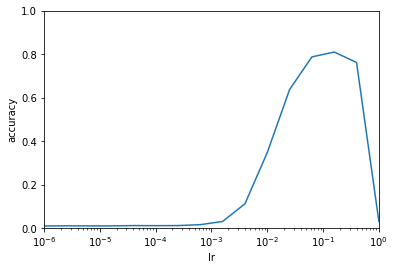

In [6]:
from matplotlib import pyplot as plt

plt.semilogx(his.history['lr'], his.history['accuracy'])
plt.axis([1e-6, 1, 0, 1])
plt.xlabel('lr')
plt.ylabel('accuracy')
plt.show()